In [66]:
import matplotlib.pyplot as plt
plt.style.use('styles/gcpeixoto-book.mplstyle')

# Erros e seus efeitos

## Introdução

Credita-se a Alexander Pope (1688 - 1744), poeta inglês, a autoria do provérbio: _"errar é humano; perdoar é divino"_ [[phrases.org.uk]](https://www.phrases.org.uk/meanings/to-err-is-human.html). Apesar de sua motivação, no século XVIII, ser o apontamento da indelével falibilidade humana, esta máxima tem uma tênue relação com os diversos tipos de erros que persistem em cálculos realizados por máquinas. Desde os primórdios dos computadores mecânicos e eletrônicos, a precisão e a confiabilidade dos cálculos têm estado no centro das atenções e ambas são afetadas pelas discrepâncias entre números reais, infinitos e contínuos, e suas representações em máquina, finitas e discretas. Nas décadas de 1940 e 1950, houve uma clara percepção de que o sistema de ponto fixo, até então utilizado, era bastante limitado para dar precisão aos cálculos e que o aparato de _hardware_ disponível na época era incapaz de lidar com situações de "sobrecarga" (_overflow_) ou "subfluxo" (_underflow_). Em outras palavras, representar números muito pequenos ou muito grandes, como $10^{-30}$ ou $543.671^3$, era algo impensável.

```{figure} figs/errare-ai.png
---
width: 400px
name: fig-errareai
---

```

Com a introdução da aritmética de ponto flutuante nos anos 1950 e 1960, os computadores passaram a representar uma quantidade significativa de números. Porém, o preço que se pagou por esse progresso foi a aparição de novos tipos de erros, como os erros de arredondamento, que ocorrem quando os números são aproximados para caber no formato de ponto flutuante. Mesmo com a implantação do padrão IEEE-754 em 1985, o qual uniformizou a representação e a manipulação de números em ponto flutuante, os erros inerentes não foram eliminados. 

A pesquisa em computação científica e de alto desempenho continua ativa e revelando que os erros são obstinados e há campo para expansão do conhecimento. Recentemente, um grupo de espanhois trouxe perspectivas promissoras para o formato _posit64_ [[Mallasén et al., 2023]](https://arxiv.org/pdf/2305.06946), uma alternativa potencialmente superior ao padrão IEEE-754. Através de diversos testes, eles concluíram  que o sistema, baseado na arquitetura RISC-V (quinta geração da _Reduced Instruction Set Computer_), oferece maior precisão, resiliência a erros de arredondamento e eficiência de armazenamento.

Neste capítulo, discutiremos algumas definições de erros computacionais e como eles se manifestam ou se propagam em cálculos numéricos aplicáveis a qualquer área do conhecimento. Historicamente, erros computacionais tiveram impacto profundo na Guerra do Golfo, no caso do desvio de rota do míssil Patriot [{ref}`clipping-patriot`], em programas espaciais, no caso da explosão do Ariane V, e até em plataformas de petróleo, no caso dos prejuízos de milhões de dólares no projeto norueguês Sleipner (veja alguns casos [[UMontreal]](https://www.iro.umontreal.ca/~mignotte/IFT2425/Disasters.html)).

## Motivação

Como forma de demonstrar que cômputos podem ter resultados distintos, consideremos a somatória (descendente, da maior para a menor parcela)

$$S_D(n) = \sum_{k=1}^n \frac{1}{k} = 1 + \frac{1}{2} + \ldots + \frac{1}{n-1} + \frac{1}{n},$$

e a sua versão escrita de forma "refletida" (ascendente, da menor para a maior parcela), ou seja,

$$S_A(n) = \sum_{k=n}^1 \frac{1}{k} = \frac{1}{n} + 1 + \frac{1}{n-1} + \ldots + \frac{1}{2} + 1.$$

É evidente que $S_A(n)$ e $S_D(n)$ são matematicamente equivalentes e devem produzir o mesmo resultado independentemente de $n$ e do sentido em que forem somadas. Porém, vejamos o que acontece ao programarmos uma pequena função para computar ambas as formas.

In [67]:
from prettytable import PrettyTable as pt

# define séries
def S(n):
    
    S_D = 0
    for k in range(1,n+1):
        S_D += 1/k        
         
    S_A = 0
    for k in range(n,0,-1):
        S_A += 1/k       
    
    # diferença    
    E = S_D - S_A
    
    return S_D, S_A, E
    
# cria objeto para tabela
tbl = pt()
tbl.field_names = ['n','S_A(n)','S_D(n)','S_D(n) - S_A(n)']
tbl.align = 'c'

# loop de teste
for n in [10**1, 10**2, 10**3, 10**4, 10**5]:
    sd, sa, e = S(n)    
    row = [n,sd,sa,e]
    tbl.add_row(row)
   
# imprime tabela
print(tbl)

+--------+--------------------+--------------------+------------------------+
|   n    |       S_A(n)       |       S_D(n)       |    S_D(n) - S_A(n)     |
+--------+--------------------+--------------------+------------------------+
|   10   | 2.9289682539682538 | 2.9289682539682538 |          0.0           |
|  100   | 5.187377517639621  | 5.1873775176396215 | -8.881784197001252e-16 |
|  1000  | 7.485470860550343  | 7.485470860550341  | 2.6645352591003757e-15 |
| 10000  | 9.787606036044348  | 9.787606036044386  | -3.730349362740526e-14 |
| 100000 | 12.090146129863335 | 12.090146129863408 | -7.283063041541027e-14 |
+--------+--------------------+--------------------+------------------------+


Como se percebe pela última coluna, os valores produzidos pelas somas para $n > 10$ não são exatamente iguais. Embora existam diferenças ínfimas nos resultados, elas não são zero, assim indicando que a maneira como computamos expressões matemáticas cujos resultados são idênticos pode levar a resultados distintos. Ter-se $S_A(n) - S_D(n) \neq 0$ equivale a admitir a presença de um "erro" – ainda que ele seja pequeno e desprezível – cuja magnitude depende da escolha de $n$.


Naturalmente, se tomássemos a versão _infinita_ de $S_D$ (ou $S_A$), chamando-a apenas de $S$ e substituindo $n$ por $\infty$, isto é, 

$$S = \sum_{k=1}^{\infty} \frac{1}{k},$$

tanto $S_D(n)$ e $S_A(n)$ seriam consideradas _aproximações_ para $S$. 

Supondo que somente $S_D(n)$ é a forma correta de "chegar perto" de $S$, a implicação

$$S = S_D(n) + \epsilon_n \Rightarrow \epsilon_n = S - S_D(n)$$

revelaria o acréscimo $\epsilon_n$ como uma quantidade não-nula coexistindo com o valor finito $n$. Uma vez que computadores são incapazes de calcular somas infinitas por limitação de memória, $\epsilon_n$ define um tipo de _erro_. Este erro é inerente ao processo de cálculo aproximado de séries infinitas. Além disso, ele dependerá de $n$, ou seja, da quantidade de termos utilizados na soma $S_D$ para aproximar o real valor de $S$.

Entretanto, estamos ainda diante de um problema de difícil tratamento, visto que a soma $S$ só pode ser obtida aproximadamente, pois $\sum_{k=1}^{\infty} \frac{1}{k}$ não é convergente. Logo, é impossível estabelecer um valor "exato" para $S$, a fim de compará-lo com suas aproximações. Caso intentássemos medir discrepâncias no cálculo desta série, teríamos que adotar um valor já aproximado para cumprir o papel de exato e utilizar outros valores também aproximados como "aproximações de uma aproximação". Embora pareça estranho e paradoxal, o que acontece em muitas situações práticas quando lidamos com um _processo iterativo_ ou de _aproximações sucessivas_ é justamente isso.

Vamos tomar os valores da tabela de $S_D(n)$. Suponhamos que $S_D(100000) = 12.090146129863408$ assumisse o papel de valor "exato" de $S$. Fosse este o caso, poderíamos calcular pelo menos quatro erros:

$$E_{10000} = S_D(100000) - S_D(10000) = 2.3025400938190224$$
$$E_{1000} = S_D(100000) - S_D(1000) = 4.604675269313067$$
$$E_{100} = S_D(100000) - S_D(100) = 6.902768612223786$$
$$E_{10} = S_D(100000) - S_D(10) = 9.161177875895154$$

Para obter cada valor acima, poderíamos escrever:

In [68]:
# O valor de S_D(n) está na entrada (i,2) da tabela, para i = 0,1,2,3,4.
# Em Python, cada um é acessível por indexação na forma [i][2]

E_100000 = tbl.rows[4][2]           # i = 4
E_10000 = E_100000 - tbl.rows[3][2] # i = 3
E_1000 = E_100000 - tbl.rows[2][2]  # i = 2
E_100 = E_100000 - tbl.rows[1][2]   # i = 1
E_10 = E_100000 - tbl.rows[0][2]    # i = 0

# Impressão de valores
print(E_100000)
print(E_10000)
print(E_1000)
print(E_100)
print(E_10)

12.090146129863408
2.3025400938190224
4.604675269313067
6.902768612223786
9.161177875895154


Não é difícil ver que o valor de $E$ em relação a $S_D(100000)$ aumenta quando tomamos valores de $n$ cada vez menores. Em outras palavras, nossas aproximações de um valor supostamente exato (aproximado) tornam-se cada vez mais pobres quando não dispomos de parcelas suficientes para somar. Além disso, usar $S_D(100000)$ como ponto de referência não é nada confiável, já que ele apenas fará com que tenhamos uma sensação ilusória de exatidão.

Se, em vez de uma série divergente, escolhermos outra, convergente, poderemos fazer cálculos de erro tomando como referência um valor definitivamente exato. Então, consideremos a série

$$S_2 = \sum_{k=1}^{\infty} \frac{1}{k^2}$$

A série $S_2$ ficou conhecida como [_Problema de Basel_](https://en.wikipedia.org/wiki/Basel_problem), proposto em 1650 pelo matemático italiano Pietro Mengoli, e solucionado por Leonhard Euler em 1734 – _Basel_ é o nome de uma cidade da Suíça, onde Euler nasceu. Graças a Euler e a teoria matemática operante nos bastidores, existe certeza suficiente de que $S_2 = \frac{\pi^2}{6}$.

Do mesmo modo como fizemos no caso anterior, geraremos uma nova tabela para valores de $S_2(n)$ com $n$ crescente até o limite de 100.000, até porque não temos como computar $S_2$ _ad infinitum_. Então, vejamos um código similar:

In [69]:
from math import pi

# define série
def S2(n):
    
    S_2 = 0
    for k in range(1,n+1):
        S_2 += 1/k**2        
             
    # valor exato
    S_2ex = pi**2/6 
    
    # diferença    
    E = S_2ex - S_2
    
    return S_2ex, S_2, E
    
# cria objeto para tabela
tbl2 = pt()
tbl2.field_names = ['n','S_2','S_2(n)','S_2 - S_2(n)']
tbl2.align = 'c'

# loop de teste
for n in [10**1, 10**2, 10**3, 10**4, 10**5]:
    s2, s2n, e = S2(n)    
    row = [n,s2,s2n,e]
    tbl2.add_row(row)
   
# imprime tabela
print(tbl2)

+--------+--------------------+--------------------+-----------------------+
|   n    |        S_2         |       S_2(n)       |      S_2 - S_2(n)     |
+--------+--------------------+--------------------+-----------------------+
|   10   | 1.6449340668482264 | 1.5497677311665408 |  0.09516633568168564  |
|  100   | 1.6449340668482264 | 1.6349839001848923 |  0.009950166663334148 |
|  1000  | 1.6449340668482264 | 1.6439345666815615 | 0.0009995001666649461 |
| 10000  | 1.6449340668482264 | 1.6448340718480652 | 9.999500016122376e-05 |
| 100000 | 1.6449340668482264 | 1.6449240668982423 | 9.999949984074163e-06 |
+--------+--------------------+--------------------+-----------------------+


Neste caso, a diferença existente na última coluna caracteriza, de fato, o _erro real_ entre o valor exato $S_2$ e suas aproximações, de modo que, neste caso,

$$E_{100000} = \frac{\pi^2}{6} - S_2(100000) = 0.000009999949984074163$$
$$E_{10000} = \frac{\pi^2}{6} - S_2(10000) = 0.00009999500016122376$$
$$E_{1000} = \frac{\pi^2}{6} - S_2(1000) = 0.0009995001666649461$$
$$E_{100} = \frac{\pi^2}{6} - S_2(100) = 0.009950166663334148$$
$$E_{10} = \frac{\pi^2}{6} - S_2(10) = 0.09516633568168564$$

A partir daí, notamos que o erro reduz-se a quase zero à medida que o valor de $n$ aumenta, assim dando-nos uma constatação, pelo menos aproximada, de que a soma, de fato, é $\pi^2/6 \approx 1.6449340668482264$. Para obtermos os valores dos erros, um código similar poderia ser implementado:

In [70]:
# Expressões do erro real
E_100000 = pi**2/6 - tbl2.rows[4][2] # i = 4
E_10000 = pi**2/6 - tbl2.rows[3][2]  # i = 3
E_1000 = pi**2/6 - tbl2.rows[2][2]   # i = 2
E_100 = pi**2/6 - tbl2.rows[1][2]    # i = 1
E_10 = pi**2/6 - tbl2.rows[0][2]     # i = 0

# Impressão
print(E_100000)
print(E_10000)
print(E_1000)
print(E_100)
print(E_10)

9.999949984074163e-06
9.999500016122376e-05
0.0009995001666649461
0.009950166663334148
0.09516633568168564


Talvez não tenha sido percebido por você, mas, até aqui, já tratamos, conceitualmente, de três tipificações de erro, a saber:

1. _erro de truncamento_, quando limitamos o número de termos de uma expansão infinita, tornando-a finita.
2. _erro real aproximado_ (ou _erro verdadeiro aproximado_), quando assumimos que o valor exato da expansão infinita (série divergente) é a soma obtida até a parcela $n$, com $n$ muito grande, mas finito, e calculamos a diferença entre este valor e a soma obtida até uma parcela anterior à $n$-ésima;
3. _erro real_ (ou _erro verdadeiro_), quando calculamos a diferença entre a soma exata (série convergente) e a soma obtida até a parcela $n$.

Curioso, não? E não para por aí! Ainda há outras definições de erro. Veremos mais algumas no decorrer do curso.

## Tipos de erros

Consideremos avaliar o polinômio $P(x) = 0.172x^3 - 0.878x^2 + 0.042x + 0.583$
no ponto $x=79.9$.

Vamos fazer o seguinte:

1. Assumir que $82132.957032$ seja o valor exato para o polinômio em $x = 79.9$.
2. Calcular $P(79.9)$ utilizando duas formas.

In [71]:
# Código para gerar polinômio cúbico com raízes reais

from numpy import random
from sympy.abc import x, a, b, c, d
from sympy import roots, lambdify

# Semente aleatória
random.seed(1)

# Um polinômio do terceiro grau terá as 3 raízes reais e distintas
# se o discriminante for > 0. Aqui, criamos um polinômio que 
# satisfaz tais condições por busca aleatória
Delta = -1
a,b,c,d = 0,0,0,0
while Delta <= 0:
    A,B,C,D = random.randn(1,4)[0,:]
    Delta = -27*A**2*D**2 + 18*A*B*C*D -4*A*C**3 - 4*B**3*D + B**2*C**2
    a,b,c,d = A,B,C,D
    
# Polinômio cúbico simbólico
P3 = a*x**3 + b*x**2 + c*x + d

# Polinômio cúbico numérico
P3n = lambdify(x,P3,'numpy')

# Raízes simbólicas
r = list(roots(P3,x).keys())
r1 = r[0]
r2 = r[1]
r3 = r[2]

# Raízes numéricas com os valores encontrados
r1n = r1.subs({'a':a, 'b':b, 'c':c, 'd': d}).evalf(10)
r2n = r2.subs({'a':a, 'b':b, 'c':c, 'd': d}).evalf(10)
r3n = r3.subs({'a':a, 'b':b, 'c':c, 'd': d}).evalf(10)

#print(P3)
#P3_ex = 0.172428207550436*x**3 - 0.877858417921372*x**2 + 0.0422137467155928*x + 0.582815213715822

In [72]:
# Valor
x = 79.9

# Forma padrão
Px = 0.172*x**3 - 0.878*x**2 + 0.042*x + 0.583

# Forma estruturada (Hörner)
PHx = x*(x*(0.172*x - 0.878) + 0.042) + 0.583 

# Impressão
print(f'P({x}) = {Px:.14f}')
print(f'PH({x}) = {PHx:.14f}')
    

P(79.9) = 82132.95064800001273
PH(79.9) = 82132.95064799999818


Como se vê, a partir da 7a. casa decimal, começamos a notar uma leve diferença do valor do polinômio, embora ambas as formas, padrão de Hörner (estruturada), sejam matematicamente equivalentes. Embora os valores sejam próximos, a forma estruturada é uma opção menos _custosa_, sob o ponto de vista computacional, visto que ela possui menos avaliações de operações aritméticas.

A forma polinomial padrão, escrita de maneira ampliada, resulta em 

$$P(x) = 0.172{\color{red}.}x{\color{red}.}x{\color{red}.}x {\color{blue}-} 0.878{\color{red}.}x{\color{red}.}x {\color{blue}+} 0.042{\color{red}.}x {\color{blue}+} 0.583,$$

ao passo que a forma de Hörner é escrita como:

$$P_H(x) = x{\color{red}.}(x{\color{red}.}(0.172{\color{red}.}x {\color{blue}-} 0.878) {\color{blue}+} 0.042) {\color{blue}+} 0.583$$

Qual é a diferença entre ambas? O número de multiplicações (vermelho) e adições/subtrações (azul) é diferente. Enquanto na forma $P(x)$, temos 6 multiplicações e 3 adições/subtrações, a forma $P_H(x)$ reduz as operações para 3 multiplicações e 3 adições/subtrações. Isso é o mesmo que dizer que o número de operações aritméticas de multiplicação foi reduzido em 50%!

A conclusão é: a avaliação de polinômios pela forma de Hörner é mais lucrativa e propensa a um erro menor.

### Erro real

O erro real (ou verdadeiro), $E$, não sinalizado, entre o valor 
exato $x$ e o aproximado $\hat{x}$ é dado por:

$$E = \hat{x} - x.$$

Note que, por convenção, se $E > 0$, erramos por superestimação ("excesso"). Por outro lado, se $E < 0$, erramos por subestimação ("omissão").

Calculamos o erro real operando com diferença simples. 

Utilizando o exemplo da seção anterior, temos:

In [73]:
# Valor exato
Px_ex = 82132.957032

# Erro real (forma padrão)
E_P = Px - Px_ex
print(E_P)

# Erro real (forma de Hörner)
E_PH = PHx - Px_ex
print(E_PH)


-0.0063839999929768965
-0.006384000007528812


### Erro absoluto

O erro absoluto, $EA$, é a versão sinalizada de $E$. Dado por

$$EA = | \hat{x} - x |,$$

ele ignora a condição de subestimação ou superestimação e se atém à diferença absoluta entre o valor exato e o valor aproximado.

A função módulo, $f(x) = | x |$, pode ser diretamente calculada com `abs`.

In [74]:
# Erro absoluto (forma padrão)
EA_P = abs(Px - Px_ex)
print(EA_P)

# Erro absoluto (forma de Hörner)
EA_PH = abs(PHx - Px_ex)
print(EA_PH)

0.0063839999929768965
0.006384000007528812


É evidente que $E_{PH} > E_P$. Entretanto, podemos verificar isso pelo seguinte teste lógico:

In [75]:
# O teste é verdadeiro
EA_PH > EA_P

True

### Erro relativo

O erro relativo, $ER$, aperfeiçoa a idea de erro absoluto a partir do momento que passa a considerar a ordem de grandeza das quantidades envolvidas, mensurando uma variação que se limita ao valor exato. Assim,

$$ER = \dfrac{ | \hat{x} - x | }{|x|} = \dfrac{ EA }{|x|}.$$

expressão que, devido à simetria da função módulo, pode ainda ser expandida para 
$$ER = \dfrac{ | x - \hat{x} | }{|x|} = 
\dfrac{|x(1 - \frac{\hat{x}}{x})|}{|x|} = \dfrac{|x| |1 - \frac{\hat{x}}{x}|}{|x|} = \bigg|1 - \frac{\hat{x}}{x}\bigg|.$$

Os erros relativos podem ser computados como:

In [76]:
ER_P = EA_P/abs(Px_ex)
print(ER_P)

ER_PH = EA_PH/abs(Px_ex)
print(ER_PH)

7.772762875796146e-08
7.772762893513656e-08


### Erro relativo percentual

O erro relativo percentual é outra forma útil de expressar a disparidade relativa entre valores. Ele é definido por:

$$ER_{\%} = ER \times 100\% = \bigg|1 - \frac{\hat{x}}{x}\bigg| \times 100\%.$$

Como não temos uma forma explícita de percentual, por cálculo, o melhor a fazer é algo como:

In [77]:
ER_Pp = ER_P * 100
print(f'{ER_Pp:e} %')

ER_PHp = ER_PH * 100
print(f'{ER_PHp:e} %')

7.772763e-06 %
7.772763e-06 %


### Erro relativo aproximado (_benchmark_)

Como vimos no exemplo motivacional deste capítulo, há casos (a maioria deles) em que não dispomos de valores exatos (obtidos por soluções analíticas, por exemplo), sendo possível estimar erros relativos apenas aproximadamente usando um _valor de referência_. Costuma-se chamar este valor de _benchmark_. Definido o _benchmark_ por $x'$, o _erro relativo aproximado_ é dado:
 
$$ER' = \dfrac{ | \hat{x} - x' | }{|x'|} = \dfrac{ EA }{|x'|}.$$


No exemplo da avaliação dos polinômios, se não dispuséssemos do valor exato, ou $P(x=79.9)$ ou $P_H(x=79.9)$ deveria ser adotado como _benchmark_. Se optássemos pelo segundo, apenas um erro relativo aproximado poderia ser calculado, a saber:

In [78]:
ER_ =  abs(PHx - Px)/abs(PHx)
print(f'{ER_:e}')

1.771751e-16


### Erro relativo aproximado percentual

O erro relativo aproximado percentual é, meramente, a versão percentual do erro relativo aproximado, logo, dado por

$$ER'_{\%} = ER' \times 100 \%.$$

### Erro de cancelamento

O erro de cancelamento ocorre quando números de grandezas próximas são subtraídos. Como exemplo de situação crítica, induzimos uma divisão por zero usando o valor do épsilon de máquina $\epsilon_M$ ao fazer 

$$\dfrac{1}{(1 + 0.25\epsilon_M) - 1}.$$

Isto ocorre porque o denominador sofre um _cancelamento subtrativo_ Uma vez que $0.25\epsilon_M < \epsilon_M$, a operação $0.25\epsilon_M$ não produz efeito sobre 1, de modo que a computação encontra um "limbo". Para a matemática exata, a operação deveria ser "diferente de zero".

In [79]:
# inf
from numpy import finfo
from warnings import filterwarnings; 
filterwarnings("ignore")

e = finfo(float).eps
1/(1 + 0.25*e - 1)

inf

### Erros de truncamento e de arredondamento

O erro de truncamento está relacionado ao "corte" abrupto de dígitos de precisão em um valor numérico ou de parcelas em uma expansão infinita. No início do capítulo, exemplificamos como uma série pode ser aproximada truncando um ou mais termos de sua expansão. 

No caso de números, o truncamento ocorre quando se ignora o valor da $k+1$-ésima casa decimal para finalidades de aproximação até a $k$-ésima casa. Por exemplo, se $x = 13.4256$, a aproximação de $x$ por truncamento até a terceira casa seria $x = 13.425$. O dígito 6 é ignorado nos cálculos. 

No caso do arredondamento, o $k$-ésimo dígito é somado de 1 se o dígito da $k+1$-ésima casa for maior ou igual a 5. A aproximação de $x$ por arredondamento até a terceira casa seria $x = 13.426$, visto que o dígito 6 é maior do que 5. A regra de arredondamento é a que usamos no cotidiano.

## Definições de erro em aprendizado de máquina

No século XXI, muito se tem falado em aprendizado de máquina, inteligência artificial e dados. Diversas definições de erro também existem neste contexto. Todavia, a conotação de "erro" nesta área costuma ser a de uma _métrica de desempenho_, pois busca medir o desempenho dos algoritmos ao operarem sobre conjuntos de dados. Essas métricas tendem a expressar distâncias entre valores reais e valores preditos. A seguir, exploraremos algumas dessas métricas sob o ponto de vista de vetores no espaço de $n$ dimensões. Em todas as fórmulas, $\bf{x}$ é o vetor de dados reais, cuja $i$-ésima componente é representada por $x_i$, e $\bf{\hat{x}}$ é o vetor de dados preditos (aproximados), cuja $i$-ésima componente é representada por $\hat{x_i}$. Assim, $n$ reflete o número de pontos de amostragem.

### Erro absoluto médio

O erro absoluto médio (_mean absolute error_, MAE) é definido como:

$$MAE = \dfrac{1}{n}\sum_{i=1}^n |x_i - \hat{x}_i|$$

O MAE é útil quando queremos minimizar a soma das diferenças absolutas.

### Erro quadrático médio

O erro quadrático médio (_mean squared error_, MSE) é definido como:

$$MSE = \dfrac{1}{n}\sum_{i=1}^n (x_i - \hat{x}_i)^2$$

### Erro absoluto médio percentual

O erro absoluto médio percentual (_mean absolute percentage error_, MAPE) é definido como:

$$MAPE = \dfrac{1}{n}\sum_{i=1}^n \dfrac { |x_i - \hat{x}_i| }{ | x_i | } \times 100$$

### Erro logarítmico quadrático médio 

O erro logarítmico quadrático médio (_mean squared logarithmic error_, MSLE) é definido como:

$$MSLE = \dfrac{1}{n}\sum_{i=1}^n [ \log(1 + x_i) - \log(1 + \hat{x}_i) ]^2$$

### Erro induzido pela norma $p$ e erro máximo

O MAE e o MSE, por exemplo, são casos particulares da definição genérica dada por:

$$
E_p = || {\bf x} - {\bf \hat{x}} ||_p = \left( \sum_{i=1}^n |x_i - \hat{x}_i|^p \right)^{\frac{1}{p}}, \ \ 1 \le p < \infty,
$$

para $p=1$ e $p=2$, respectivamente. Em particular, a chamada "norma do máximo" é definida por

$$
E_{\infty} = || {\bf x} - {\bf \hat{x}} ||_{\infty} = \max \{ |x_i - \hat{x}_i| \}, 
$$

que mede a maior diferença absoluta entre o vetor de valores reais e o vetor de valores preditos.

A norma $p$ é chamada de _norma de Minkowski_. As diferentes normas decorrentes da escolha de $p$ são usadas em contextos diferentes para medir mudanças específicas. Quanto maior é o valor de $p$, mais ela se concentra em captar discrepâncias maiores. Assim, normas menores são mais robustas a _outliers_. Quando $p=1$, temos a _norma de Manhattan_; quando $p=2$, temos a _norma Euclidiana_, bastante conhecida de outras disciplinas.


```{admonition} Curiosidade
:class: dropdown

Nos últimos anos, métodos de aprendizagem profunda vêm sendo aplicados à identificação automatizada de corpos salinos em imagens sísmicas tanto para finalidades de exploração de combustíveis fósseis, como também para armazenamento geológico de carbono. Em aplicações dessa natureza, o gabarito, em geral, é uma imagem interpretada por um geólogo profissional. Algoritmos de classificação, por sua vez, tentam delinear a mesma estrutura geológica obtida pelo humano baseando-se em métricas formuladas a partir de definições de erro como as que estudamos nesta seção. Para saber mais, veja o artigo [Identification of Salt Deposits on Seismic Images Using Deep Learning Method for Semantic Segmentation](https://www.mdpi.com/2220-9964/9/1/24).
```

### Calculando o desempenho

Usando a biblioteca `scikit-learn`, é possível utilizar funções já disponíveis no módulo `sklearn.metrics` para calcular essas métricas. Abaixo, utilizamos um exemplo genérico para um conjunto de valores reais e valores preditos associados aos reais para $n=4$. As plotagens resumem a dispersão entre valores reais e preditos e os erros dados por cada métrica.

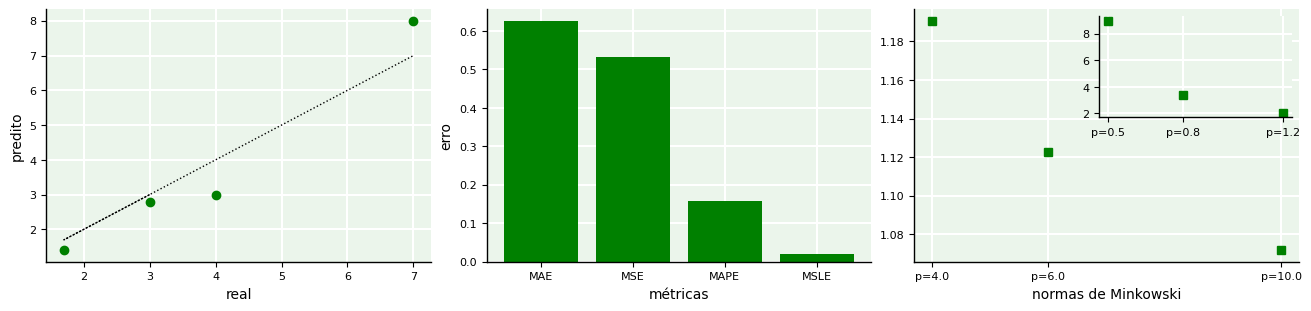

In [80]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics.pairwise import pairwise_distances as pNorm

from numpy import array
from matplotlib.pyplot import subplots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker

# conjunto de dados
x = array([3.0, 1.7, 4.0, 7.0]) # valores reais
xhat = array([2.8, 1.4, 3.0, 8.0]) # valores preditos

# erros
mae = MAE(x,xhat)
mse = MSE(x,xhat)
mape = MAPE(x,xhat)
msle = MSLE(x,xhat)

# normas de Minkowski
norms = []
P = [0.5, 0.8, 1.2, 4.0, 6.0, 10.0] # valores p

# calcula por matrizes de distâncias, mas armazena valor único
for p in P:
    norms.append(pNorm([x],[xhat],metric='minkowski',p=p).ravel()[0])


# gráficos
fig, ax = subplots(1,3,figsize=(13,3),constrained_layout=True)
ax[0].plot(x,x,'k:',lw=1.0)
ax[0].plot(x,xhat,'og')
ax[0].set_xlabel('real'); ax[0].set_ylabel('predito')

ax[1].bar(x=['MAE','MSE','MAPE','MSLE'],height=[mae,mse,mape,msle],color='g')
ax[1].set_xlabel('métricas'); ax[1].set_ylabel('erro')

ax[2].plot(P[3:],norms[3:],'sg')
ax[2].xaxis.set_major_locator(mticker.FixedLocator(P[3:]))
ax[2].set_xticklabels(list(map(lambda x: f'p={x:.1f}',P[3:])))

# eixo embutido
axi = inset_axes(ax[2],width="50%", height="40%", loc="upper right")
axi.plot(P[:3],norms[:3],'sg')
axi.xaxis.set_major_locator(mticker.FixedLocator(P[:3]))
axi.set_xticklabels(list(map(lambda x: f'p={x:.1f}',P[:3])))

ax[2].set_xlabel('normas de Minkowski'); ax[1].set_ylabel('erro');

Percebe-se que cada métrica retorna um valor diferente para o erro entre os valores exatos e os aproximados. Cabe ao usuário interpretar qual faz mais sentido para o conjunto de dados em análise.

## Exemplos aplicados

### Erros pontuais na função de Airy

A função de Airy é solução da equação de Schrödinger da mecânica quântica. Ela muda o seu comportamento de oscilatório para exponencial. A fim de demonstrar como o erro é uma função, dependente do ponto onde é avaliado, criaremos uma simulação.

Criaremos uma função "perturbada" que desempenhará o papel de função de Airy aproximada, enquanto menteremos a função de Airy verdadeira como exata. Em seguida, criaremos outra função de utilidade para calcular diretamente o erro relativo pontual.


In [81]:
from scipy import special
import numpy as np

# Eixo das abscissas
x = np.linspace(-10, -2, 100)

# Funções de Airy e suas derivadas (solução exata)
A, aip, bi, bip = special.airy(x)

# Função de Airy perturbada
A_ = 1.152*A + 0.056*np.cos(x) 

Podemos usar o conceito de _função anônima_ (`lambda`) para calcular diretamente o erro relativo percentual para cada ponto $x$. Assim, seja:

$$ER_{\text{Airy}}(x) = \frac{\mid \ \hat{A}(x) - A(x) \ \mid}{\mid \ A(x) \ \mid},$$

onde $\hat{A}(x)$ é a função de Airy aproximada e $A(x)$ é a função de Airy exata. Então:

In [82]:
# Define função anônima para erro relativo
ai = lambda f,f_: (abs(f_ - f)/abs(f))*100

# calcula erro relativo para função de Airy e sua aproximação
E_airy = ai(A,A_)

A seguir, mostramos a plotagem das funções exatas e aproximadas, bem como do erro relativo pontual.

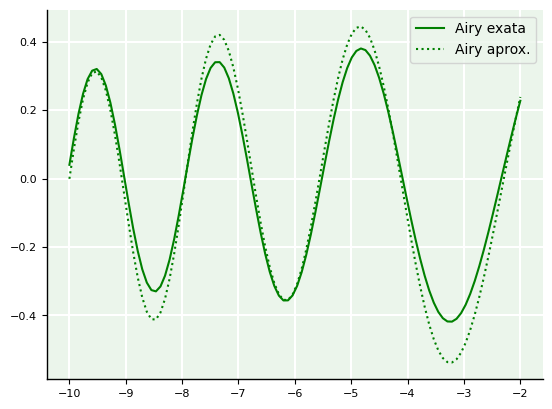

In [83]:
# Plotagem das funções 
from matplotlib.pyplot import plot, grid, legend

plot(x, A, 'g-', label='Airy exata')
plot(x, A_, 'g:', label='Airy aprox.')
legend(loc='upper right');

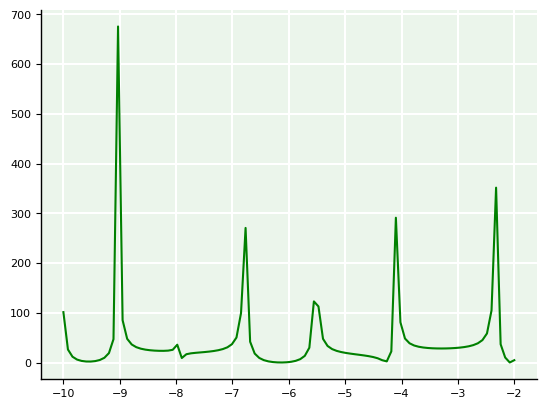

In [84]:
# Plotagem do erro 
plot(x, E_airy,'g')

### Avaliação de algoritmos de ordenação

Vamos considerar um cenário em que estamos avaliando a eficiência de dois algoritmos de ordenação: o algoritmo de ordenação por inserção (_insertion sort_) e o algoritmo de ordenação rápida (_quick sort_). Suponha que temos um conjunto de dados com 10.000 elementos e queremos comparar o tempo de execução teórico e o medido para ambos os algoritmos.

Consideremos: 

- $x$: tempo de execução teórico do algoritmo.
- $\hat{x}$: tempo de execução medido do algoritmo.
- $ER = 1 - \dfrac{\hat{x}}{x}$

O _insertion sort_ possui complexidade teórica de $O(n^2)$. Consideremos que o tempo teórico para 10.000 elementos seja de 50 segundos. O _quick sort_ possui complexidade teórica de $O(n \, \log \, n)$. Consideremos que o tempo teórico para 10.000 elementos seja de 2 segundos.

Após executar os algoritmos em uma máquina específica, suponhamos que tenhamos obtido os seguintes tempos de execução:

- _insertion sort_: 55 segundos.
- _quick sort_: 2.5 segundos.

O cálculo do erro relativo mostra que:

- _insertion sort_: $ER = 1 - \frac{55}{50} = 1 - 1.1 = -0.1 = -10\%$
- _quick sort_: $ER = 1 - \frac{2.5}{2} = 1 - 1.25 = -0.25 = -25\%$.

Ou seja, para o _insertion sort_, o erro relativo de -10% indica que o algoritmo demorou 10% mais do que o esperado, o que pode ser atribuído a fatores como sobrecarga de processamento ou otimizações que não foram realizadas. Para o _quick sort_, o erro relativo de -25% indica que o algoritmo demorou 25% mais do que o esperado, sugerindo que o algoritmo pode não ter se comportado da melhor maneira para este conjunto de dados específico, ou que a implementação usada não foi a mais eficiente.

Esses cálculos de erro relativo são essenciais para avaliar o desempenho dos algoritmos em ambientes reais, comparando-os com as expectativas teóricas. Eles ajudam a identificar discrepâncias que podem surgir devido a vários fatores, como características do hardware, implementações específicas do algoritmo, e peculiaridades dos dados de entrada.

### Erros de precificação imobiliária por redes neurais

Vamos considerar um cenário onde estamos treinando uma rede neural para prever preços de imóveis com base em características como área, número de quartos, localização, etc. Para avaliar o desempenho da rede neural, usaremos o MSE e o MAE.

1. **Dados do Conjunto de Treinamento e Teste**
   - Temos um conjunto de dados com 1.000 amostras de preços de imóveis.

2. **Treinamento da Rede Neural**
   - A rede neural é treinada com um conjunto de treinamento e avaliada com um conjunto de teste.

3. **Resultados do Conjunto de Teste**
   - Valores reais dos preços dos imóveis: $\mathbf{x} = [200 \ \ 300 \ \ 250 \ \ 500 \ \ 400]^T$
   - Valores previstos pela rede neural $\mathbf{\hat{x}} = [210 \ \ 290 \ \ 240 \ \ 520 \ \ 410]^T$

4. **Cálculo do MSE**
$\text{MSE} = \frac{1}{5} \left[ (200 - 210)^2 + (300 - 290)^2 + (250 - 240)^2 + (500 - 520)^2 + (400 - 410)^2 \right]$
$\text{MSE} = \frac{1}{5} \left[ 100 + 100 + 100 + 400 + 100 \right] = \frac{1}{5} \times 800 = 160$

5. **Cálculo do MAE**
$\text{MAE} = \frac{1}{5} \left[ |200 - 210| + |300 - 290| + |250 - 240| + |500 - 520| + |400 - 410| \right]$
$\text{MAE} = \frac{1}{5} \left[ 10 + 10 + 10 + 20 + 10 \right] = \frac{1}{5} \times 60 = 12$

6. **Interpretação dos Resultados**
   - **MSE**: Um valor de 160 indica que, em média, os quadrados dos erros são relativamente altos. Como o MSE penaliza mais fortemente os grandes erros, este valor sugere que há algumas previsões com grandes discrepâncias.
   - **MAE**: Um valor de 12 indica que, em média, os erros absolutos entre as previsões e os valores reais são de 12 unidades monetárias. O MAE sendo menor que o MSE sugere que a maioria dos erros são pequenos, mas existem alguns grandes erros que estão influenciando o MSE.
   - **Ajuste do Modelo**: Se o MSE for muito maior que o MAE, isto pode indicar a presença de outliers que estão afetando negativamente o desempenho do modelo. Nesse caso, pode ser útil investigar os outliers e ajustar o modelo ou os dados de treinamento.

7. **Avaliação de Desempenho**
Ambas as métricas são úteis para avaliar a precisão do modelo, mas cada uma tem suas vantagens. O MSE é mais sensível a grandes erros, enquanto o MAE é mais intuitivo e menos sensível a outliers. O uso de MSE e MAE permite uma avaliação completa do desempenho de uma rede neural. Enquanto o MSE fornece uma visão detalhada dos erros grandes, o MAE oferece uma métrica mais robusta contra outliers, facilitando a interpretação dos resultados e a melhoria do modelo.

In [85]:
plt.rcdefaults()